The question that this notebook aims to answer is: Are movies that are released in more countries more profitable?

AN executive summary of the entire notebook goes here

business understanding
-talk abotu the project

data mining
-where are u getting alternateive data and why

Data cleaning

Data exploration

Feature Engineering
-throughout the notebook explaining what changes you're making and why

Predictive modelling

Data Visualization



# Import packages and set SQL cursor

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import os
%matplotlib inline

conn = sqlite3.connect('movies_db.sqlite')
cur = conn.cursor()

## Adjust view space

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Bring in data from our SQL database

## Creating our Countries per Movie DataFrame

In [4]:
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('bom_movie_gross',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [5]:
cur.execute('''SELECT primary_title, region
                FROM imdb_title_akas a
                JOIN imdb_title_basics b
                ON a.title_id = b.tconst
                ;''')
df_title_region = pd.DataFrame(cur.fetchall())
df_title_region.columns = [x[0] for x in cur.description]
df_title_region.head()

,primary_title,region
0,Sunghursh,IN
1,Sunghursh,None
2,Sunghursh,IN
3,Sunghursh,IN
4,Sunghursh,IN


## Creating our Movie Budgets/Revenues DataFrame 

In [6]:
cur.execute('''SELECT * 
                FROM tn_movie_budgets
                ;''')
df_movie_moneys = pd.DataFrame(cur.fetchall())
df_movie_moneys.columns = [x[0] for x in cur.description]
df_movie_moneys.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


# Data Cleaning & Converting 

## Cleaning & Converting - Country Releases per Movie 

**Drop 'None' types from the region feature & check the unique values**

In [7]:
df_title_region = df_title_region.dropna()
df_title_region['region'].unique()

array(['IN', 'XWW', 'VE', 'PL', 'DE', 'PT', 'BR', 'US', 'GB', 'IT', 'RU',
       'AR', 'ES', 'FR', 'CL', 'AU', 'CA', 'NL', 'BG', 'HR', 'HU', 'SE',
       'RO', 'HK', 'FI', 'EE', 'DK', 'LT', 'PK', 'GE', 'TR', 'GR', 'IL',
       'UY', 'RS', 'SI', 'CZ', 'UA', 'MX', 'JP', 'VN', 'PE', 'AZ', 'LV',
       'NO', 'SK', 'AL', 'KR', 'CO', 'EG', 'XEU', 'IR', 'SG', 'BE', 'IS',
       'CH', 'BA', 'ZA', 'CN', 'BD', 'LU', 'CU', 'AM', 'AT', 'MK', 'PH',
       'XSA', 'BO', 'TW', 'LB', 'PR', 'PA', 'IE', 'MY', 'CM', 'KZ', 'NZ',
       'TH', 'ID', 'BY', 'MA', 'CG', 'CR', 'XAS', 'MD', 'PY', 'EC', 'GT',
       'DO', 'TZ', 'DZ', 'BS', 'HT', 'JM', 'CY', 'MZ', 'NG', 'SL', 'PG',
       'MO', 'MN', 'XYU', 'ET', 'AE', 'PS', 'ZW', 'MW', 'FJ', 'MC', 'IQ',
       'SV', 'GL', 'KE', 'CSHH', 'QA', 'AO', 'GP', 'NP', 'ZM', 'AF', 'GH',
       'SZ', 'UG', 'CD', 'ME', 'JO', 'KG', 'RW', 'SN', 'LR', 'NI', 'KH',
       'AG', 'NE', 'VI', 'LI', 'UZ', 'HN', 'TT', 'BF', 'XKV', 'SUHH',
       'TN', 'CSXX', 'LK', 'AN', 'TG', 'BH', 'L

**I noticed that there were different types of country codes in this list. This led to more research to see how I could check that these were all accurate. I found the |pycountry| library and installed/imported it below.**

In [8]:
import pycountry

In [9]:
def alpha_code_check(value):
    if len(value) == 2:
        value = 'aplha_2'
        return value
    elif len(value) == 3:
        value = 'alpha_3'
        return value
    else:
        value = 'alpha_4'
        return value


df_title_region['alpha_code'] = df_title_region['region'].map(lambda x: alpha_code_check(x))
print(df_title_region['alpha_code'].value_counts())
df_title_region.head()

aplha_2    259181
alpha_3     19206
alpha_4        23
Name: alpha_code, dtype: int64


,primary_title,region,alpha_code
0,Sunghursh,IN,aplha_2
2,Sunghursh,IN,aplha_2
3,Sunghursh,IN,aplha_2
4,Sunghursh,IN,aplha_2
5,One Day Before the Rainy Season,XWW,alpha_3


**Great, now we have a new column that identifies the type of alpha code in that row.**

**Let's now convert that to a country name using |pycountry|.**

In [10]:
def country_alpha_converter(value):
    '''This is a function to map columns and convert values of country alpha 
    codes to country names.'''
    
    if len(value) == 2:
        x = pycountry.countries.get(alpha_2=value)
        if x == None:
            return 'None'
        return x.name
    elif len(value) == 3:
        x = pycountry.countries.get(alpha_3=value)
        if x == None:
            return 'None'
        return x.name
    else:
        x = pycountry.historic_countries.get(alpha_4=value) #old country codes
        if x == None:
            return 'None'
        return x.name

df_title_region['country'] = df_title_region['region'].map(lambda x: country_alpha_converter(x))
df_title_region.head()

,primary_title,region,alpha_code,country
0,Sunghursh,IN,aplha_2,India
2,Sunghursh,IN,aplha_2,India
3,Sunghursh,IN,aplha_2,India
4,Sunghursh,IN,aplha_2,India
5,One Day Before the Rainy Season,XWW,alpha_3,None


**Looks good, though we can clearly see that there are lots of duplicates, as well as a 'none' in the country feature.**

In [11]:
df_title_region[(df_title_region['alpha_code'] == 'alpha_3')
                | 
                (df_title_region['alpha_code'] == 'alpha_4')
               &
               (df_title_region['country'] == 'None')].head()

,primary_title,region,alpha_code,country
5,One Day Before the Rainy Season,XWW,alpha_3,None
26,The Wandering Soap Opera,XWW,alpha_3,None
47,So Much for Justice!,XWW,alpha_3,None
56,Children of the Green Dragon,XWW,alpha_3,None
60,The Tragedy of Man,XWW,alpha_3,None


**Based on the information provided above, we can see that a lot of country_codes containing alpha_3 OR alpha_4 also have a 'None' value for their country feature, making these rows essentially useless for our needs.  To proceed, we will drop all rows with the value of 'None' for the 'country' feature.**

In [12]:
df_title_region = df_title_region[df_title_region['country'] != 'None']
df_title_region.head()

,primary_title,region,alpha_code,country
0,Sunghursh,IN,aplha_2,India
2,Sunghursh,IN,aplha_2,India
3,Sunghursh,IN,aplha_2,India
4,Sunghursh,IN,aplha_2,India
6,One Day Before the Rainy Season,IN,aplha_2,India


In [13]:
df_title_region['alpha_code'].value_counts()

aplha_2    259176
alpha_4        23
Name: alpha_code, dtype: int64

**Looks like all of the alpha_3 codes went along with the 'none' values. Let's see what we have left for alpha_4 codes.**

In [14]:
df_title_region[df_title_region['alpha_code'] == 'alpha_4']

,primary_title,region,alpha_code,country
38031,Mumu,CSHH,alpha_4,"Czechoslovakia, Czechoslovak Socialist Republic"
60649,Like Crazy,SUHH,alpha_4,"USSR, Union of Soviet Socialist Republics"
63250,Battery Man,CSXX,alpha_4,Serbia and Montenegro
89541,Waldheim-KGB Agent Kurt,CSXX,alpha_4,Serbia and Montenegro
138179,Albertov Put,CSXX,alpha_4,Serbia and Montenegro
146591,Kosma,CSXX,alpha_4,Serbia and Montenegro
153295,Danube Floating Free,CSXX,alpha_4,Serbia and Montenegro
154420,Drugo ime za slobodu,CSXX,alpha_4,Serbia and Montenegro
160770,Zivan Makes a Punk Festival,CSXX,alpha_4,Serbia and Montenegro
165231,Skile,CSXX,alpha_4,Serbia and Montenegro


**As we can see above, the countries that were assigned alpha_4 codes are no longer countries today.  We can safely remove these from our analysis as well.**

In [15]:
df_title_region = df_title_region[df_title_region['alpha_code'] != 'alpha_4']
df_title_region['alpha_code'].value_counts()

aplha_2    259176
Name: alpha_code, dtype: int64

**Great, now let's drop the alpha_code and region columns.**

In [16]:
df_title_region = df_title_region.drop(['alpha_code', 'region'], axis=1)
print(df_title_region.shape)
df_title_region.head()

(259176, 2)


,primary_title,country
0,Sunghursh,India
2,Sunghursh,India
3,Sunghursh,India
4,Sunghursh,India
6,One Day Before the Rainy Season,India


**OK, so now we are only left with the duplicates. Let's drop them now so that later on our lists of countries (for our country_count feature) will be accurate. Let's also update the name of our DF as well.**

In [17]:
df_title_country = df_title_region.drop_duplicates()
print(df_title_country.shape)
df_title_country.head()

(237752, 2)


,primary_title,country
0,Sunghursh,India
6,One Day Before the Rainy Season,India
9,The Other Side of the Wind,"Venezuela, Bolivarian Republic of"
10,The Other Side of the Wind,Poland
11,The Other Side of the Wind,Germany


**Dropped about 20K duplicates, very nice.  Now let's build out our feature containing a list of each country per movie.**

In [18]:
df_title_countrylist = df_title_country.groupby('primary_title')['country'].apply(list).reset_index(name='country_list')
print(df_title_countrylist.shape)
df_title_countrylist.head()

(114284, 2)


,primary_title,country_list
0,!Women Art Revolution,"[Russian Federation, United States]"
1,#1 Serial Killer,[United States]
2,#5,[United States]
3,#50Fathers,[United States]
4,#66,[Indonesia]


**We are now down to 114,284 rows, and with the cleaning that we have done up to this point, it seems fair to assume that all of these movies are unique, but just to be safe, lets check with a .value_counts() method.**

In [19]:
df_title_countrylist['primary_title'].value_counts()

Powerless Federal Agent 8                                                          1
The Ultimate Accessory                                                             1
Crónica de un comité                                                               1
Sitting Next to Zoe                                                                1
8 Hours                                                                            1
JazzFest: A Cleveland Tradition                                                    1
S&M Lawn Care                                                                      1
Lollipop                                                                           1
Tainted Souls                                                                      1
I Know Jack Venice                                                                 1
This Wretched Life                                                                 1
I'm Not Dead Yet                                                 

In [20]:
df_title_countrylist

,primary_title,country_list
0,!Women Art Revolution,"[Russian Federation, United States]"
1,#1 Serial Killer,[United States]
2,#5,[United States]
3,#50Fathers,[United States]
4,#66,[Indonesia]
5,#BKKY,[Thailand]
6,#BeRobin the Movie,[United States]
7,#Beings,[Germany]
8,#Bicyclediary,[Finland]
9,"#Bitch, les filles et la violence",[Canada]


**Perfect!  Next we are going to make a simple feature that counts the number of countries each movie was released in.  This is easily achieved by calculating the length of the country_list feature for each movie using some nice list comprehension. Then update the DF name to be a bit more descriptive.**

In [32]:
df_title_countrylist['country_count'] = [len(x) for x in df_title_countrylist['country_list']]
df_title_countrylist_count = df_title_countrylist
df_title_countrylist_count.head()

,primary_title,country_list,country_count
0,!Women Art Revolution,"[Russian Federation, United States]",2
1,#1 Serial Killer,[United States],1
2,#5,[United States],1
3,#50Fathers,[United States],1
4,#66,[Indonesia],1


**Here we are going to subset the dataframe.  We are going to do so based on whether a movie was either a domestic or international release.  This significant because we can now compare the two different release types and decide whether international releases are even worth it, should they turn out to perhaps be more expensive or less profitable.  We will create the domestic dataframe by filtering for movies whose country_count feature has a value of 1.**

In [35]:
df_domestic_title_country = df_title_countrylist_count[
    df_title_countrylist_count[
        'country_count'
    ] == 1
]

df_domestic_title_country = df_domestic_title_country.drop('country_count', axis=1)
# Reassigned variable to avoid 'A value is trying to be set on a copy of a slice from a DataFrame.' error.
df_domestic_title_country['country_list'] = df_domestic_title_country['country_list'].map(lambda x: ''.join(x))
df_domestic_title_country.head()

,primary_title,country_list
1,#1 Serial Killer,United States
2,#5,United States
3,#50Fathers,United States
4,#66,Indonesia
5,#BKKY,Thailand


**Great, now we can see all of the domestic movie releases. If we want to, we can also group this dataframe by its country feature and create a list of domestic movies released in each one respectively.**

In [36]:
df_domestic_country_movie_list = df_domestic_title_country.groupby('country_list')['primary_title'].apply(list).reset_index(name='movie_list')
df_domestic_country_movie_list.head()

,country_list,movie_list
0,Afghanistan,"[A Man's Desire for Fifth Wife, Afghanistan, A..."
1,Albania,"[6 Idiotet, A Shelter Among the Clouds, Albani..."
2,Algeria,"[Abd El-Kader, Africa Is Back, Azib Zamoum, a ..."
3,American Samoa,"[Pacmakman, Seki A Oe: A Crazy Samoan Love Sto..."
4,Andorra,"[73', Impacto]"


**Or we can just see how many domestic movies per country without a list of titles.  We can rearrange this as needed to prepare for a future merge or join with another dataset.**

In [37]:
df_dom_movies_per_country = df_domestic_title_country
df_dom_movies_per_country['movies_per_country'] = 1
df_dom_movies_per_country = df_domestic_title_country.groupby('country_list').sum()
df_dom_movies_per_country.head()

,movies_per_country
country_list,
Afghanistan,29
Albania,35
Algeria,42
American Samoa,3
Andorra,2


**Now we are going to create out dataframe of international movies, those with more than 1 in their country_count feature.
We then reset the index just to make it look nicer, and to lessen any potential merge or join issues later.**

In [39]:
df_int_title_clist_ccount = df_title_countrylist_count[
    df_title_countrylist_count[
        'country_count'
    ] > 1
]

df_int_title_clist_ccount = df_int_title_clist_ccount.reset_index().drop('index', axis=1)
df_int_title_clist_ccount.head()

,primary_title,country_list,country_count
0,!Women Art Revolution,"[Russian Federation, United States]",2
1,#Female Pleasure,"[Lithuania, Poland, Germany, Switzerland, Spain]",5
2,#FollowFriday,"[United States, France, Brazil]",3
3,#Horror,"[United States, Russian Federation]",2
4,#REALITYHIGH,"[United States, Russian Federation]",2


## Cleaning & Converting - Domestic & International Budgets/Revenues

**GET SOME INFORMATION ABOUT THIS DATA SET AND SEE IF ANYTHING LOOKS OFF**

In [40]:
print(df_movie_moneys.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 5 columns):
release_date         5234 non-null datetime64[ns]
primary_title        5234 non-null object
production_budget    5234 non-null float64
domestic_gross       5234 non-null float64
worldwide_gross      5234 non-null float64
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 245.3+ KB
None


In [41]:
df_movie_moneys.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**Let's drop the 'id' column here.**

In [43]:
df_movie_moneys = df_movie_moneys.drop('id', axis=1)
df_movie_moneys.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**Clean and convert the 'production_budget', 'domestic_gross', and 'worldwide_gross' columns from strings to floats using the function created below**

In [45]:
def string_to_float_converter(value, to_replace=None, new_value='', new_dtype=float):
    
    '''This function cleans and converts any column of strings with UP TO 3
    variables at a time. This function is designed to be mapped along columns
    in a Pandas DataFrame and takes in a (value) and the desired string characters
    to be replacesd (to_replace). By default, new_value is '' and new_dtype 
    is 'float', though they may be changed.
    
    Returns:
    A cleaned and converted value.
    
    Example: 
    df['col'].map(lambda x: string_to_float_converter(x, ['$',',','&']))''' 
    
    if type(to_replace) == list:
        n = len(to_replace)
        if n == 2:
            return new_dtype(value.replace(to_replace[0], new_value).replace(to_replace[1], new_value))
        if n == 3:
            return new_dtype(value.replace(to_replace[0], new_value).replace(to_replace[1], new_value).replace(to_replace[2]))
    else:
        return new_dtype(value.replace(to_replace, new_value))

# df_movie_moneys['worldwide_gross'] = df_movie_moneys['worldwide_gross'].map(lambda x: string_to_float_converter(x, to_replace=['$',',']))
# df_movie_moneys['production_budget'] = df_movie_moneys['production_budget'].map(lambda x: string_to_float_converter(x, to_replace=['$',',']))
# df_movie_moneys['domestic_gross'] = df_movie_moneys['domestic_gross'].map(lambda x: string_to_float_converter(x, to_replace=['$',',']))

df_movie_moneys.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**Convert the 'release_date' column to pandas datetime objects.**

In [46]:
df_movie_moneys['release_date'] = pd.to_datetime(df_movie_moneys['release_date'])
df_movie_moneys.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**Excellent, now let's have a closer look at our numeric columns.**

In [47]:
print(df_movie_moneys.shape)
df_movie_moneys.describe()

(5234, 5)


,production_budget,domestic_gross,worldwide_gross
count,5.234000e+03,5.234000e+03,5.234000e+03
mean,3.403348e+07,4.625747e+07,1.007615e+08
std,4.296048e+07,7.029651e+07,1.811226e+08
min,1.100000e+03,3.880000e+02,4.010000e+02
25%,6.500000e+06,4.289718e+06,8.142571e+06
50%,2.000000e+07,2.198422e+07,3.543844e+07
75%,4.500000e+07,5.756598e+07,1.093357e+08
max,4.250000e+08,9.366622e+08,2.776345e+09


**Lots to see here.  The first thing to notice is the 0 values in the 'domestic_gross' and 'worldwide_gross' columns.  Let's have a look at what kinds of movies fit this criteria beforehand.**

In [48]:
print(df_movie_moneys[(df_movie_moneys['worldwide_gross'] == 0)
                                  |
                                  (df_movie_moneys['domestic_gross'] == 0)].shape)
df_movie_moneys[(df_movie_moneys['worldwide_gross'] == 0)
                                  |
                                  (df_movie_moneys['domestic_gross'] == 0)]

(0, 5)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross


**If we sort by 'release_date' then we can see that some of these movies have not even been released yet.  Furthermore, there are release dates that have passed and yet these movies still have no financial information.  Finally we have some examples of movies where they have a 'worldwide_gross' figure, yet no 'domescit_gross' figure.  I can think of no good, or logical reason as to why this may be the case other than error in the data, therefore we will drop these rows.  This constitutes a drop of 10% of our data, though it is likely that most of these movies we did not have country information for either.**

In [49]:
df_movie_moneys = df_movie_moneys[(df_movie_moneys['worldwide_gross'] != 0)
                                  &
                                  (df_movie_moneys['domestic_gross'] != 0)]
print(df_movie_moneys.describe())
print(df_movie_moneys.shape)
df_movie_moneys.head()

       production_budget  domestic_gross  worldwide_gross
count       5.234000e+03    5.234000e+03     5.234000e+03
mean        3.403348e+07    4.625747e+07     1.007615e+08
std         4.296048e+07    7.029651e+07     1.811226e+08
min         1.100000e+03    3.880000e+02     4.010000e+02
25%         6.500000e+06    4.289718e+06     8.142571e+06
50%         2.000000e+07    2.198422e+07     3.543844e+07
75%         4.500000e+07    5.756598e+07     1.093357e+08
max         4.250000e+08    9.366622e+08     2.776345e+09
(5234, 5)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**Finally, lets's change the feature name from 'movie' to 'primary_title' so as to make future merges less stressful!**

In [50]:
df_movie_moneys = df_movie_moneys.rename(columns={'movie':'primary_title'})
df_movie_moneys.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


**We have left the rest of the outlier data in for now so that we can have a better look at the data through EDA before determining the best method of dealing with them.**

# Data Exploration & Feature Engineering

**The first step in our Data Exploration & Feature Engineering Phase will be to bring our data together and start to have a look at what stands out.**

In [51]:
df_int_movies_analysis_inner = df_movie_moneys.merge(df_int_title_clist_ccount, on='primary_title')
print(df_int_movies_analysis_inner.shape)
df_int_movies_analysis_inner.head()

(1760, 7)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[Japan, Sweden, Peru, Ukraine, United States, ...",39
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[France, Mexico, Italy, Poland, Hungary, Portu...",32
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[Azerbaijan, Peru, United States, Israel, Mexi...",34
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[Argentina, Spain, Serbia, United States, Czec...",31
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[Serbia, Argentina, United States, Hungary, Vi...",29


**Great! We are now down to our ~1800 rows.  This is less than half of the original 'bom_movies_gross' data set but we now have a lot more information about each movie.  Before we look at any relationships, let's add a few more important features to this dataset.  Our question is surrounding profitability so it makes sense to add in features related to that measurement.  Let's add a foreign_gross', 'domestic_profit', 'total_profit', and 'return_on_investment' each to this dataset.**

In [52]:
df_int_movies_analysis_inner['foreign_gross'] = df_int_movies_analysis_inner['worldwide_gross'] - df_int_movies_analysis_inner['domestic_gross']
df_int_movies_analysis_inner['domestic_profit'] = df_int_movies_analysis_inner['domestic_gross'] - df_int_movies_analysis_inner['production_budget']
# df_int_movies_analysis['foreign_profit'] = df_int_movies_analysis['foreign_gross'] - df_int_movies_analysis['production_budget']
df_int_movies_analysis_inner['total_profit'] = df_int_movies_analysis_inner['worldwide_gross'] - df_int_movies_analysis_inner['production_budget']
df_int_movies_analysis_inner['return_on_investment'] = df_int_movies_analysis_inner['worldwide_gross'] / df_int_movies_analysis_inner['production_budget']

df_int_movies_analysis_inner.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,domestic_profit,total_profit,return_on_investment
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[Japan, Sweden, Peru, Ukraine, United States, ...",39,8.046000e+08,-169536125.0,6.350639e+08,2.546673
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[France, Mexico, Italy, Poland, Hungary, Portu...",32,1.070000e+08,-307237650.0,-2.002376e+08,0.427892
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[Azerbaijan, Peru, United States, Israel, Mexi...",34,9.440081e+08,128405868.0,1.072414e+09,4.243841
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[Argentina, Spain, Serbia, United States, Czec...",31,1.369319e+09,378815482.0,1.748134e+09,6.827114
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[Serbia, Argentina, United States, Hungary, Vi...",29,4.269209e+08,-70975705.0,3.559452e+08,2.186484


  **That was easy! Now that we have the features that we would liketo see, let's start out with Seaborn's .pairplot and see what kinds of relationships exist.** 

C:\Users\tcast\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


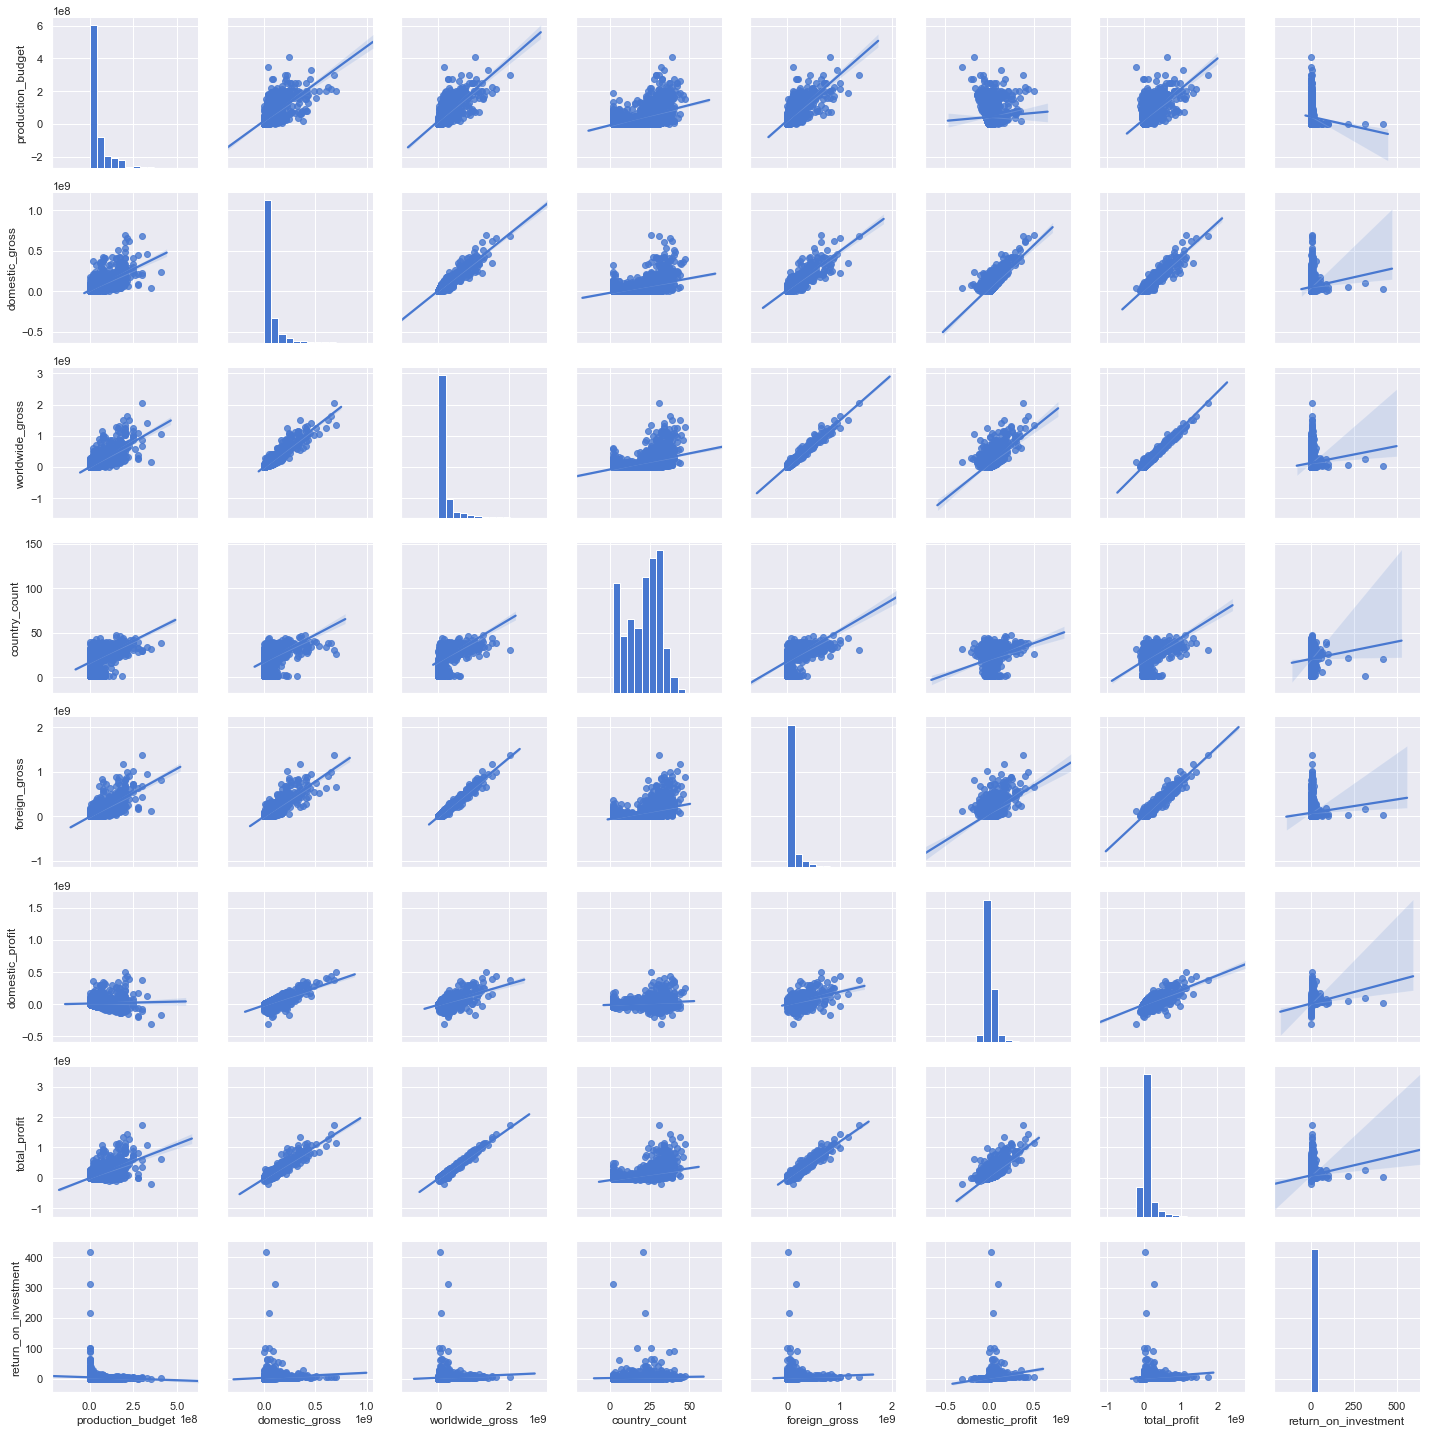

In [53]:
sns.set(context='notebook', style='darkgrid', color_codes=True, palette='muted')

sns.pairplot(df_int_movies_analysis_inner, kind='reg');

**This is great! On our first look we can already see that a positive relationship exists between 'country_count' and our gross figures. Though remember that we are interested in profitability, not just revenue. We can also observe that we have a lot of positively-skewed features for budget and revenues. Next, let's take a closer look at our individual features using a boxplot to help us better contextualize the outliers.** 

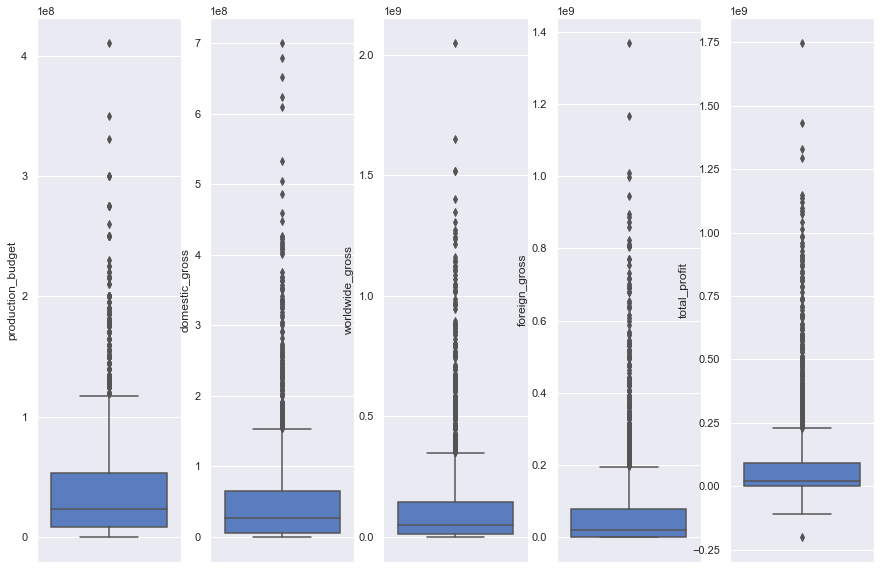

In [66]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(15,10))

ax_list = [ax1, ax2, ax3, ax4, ax5]
x = [df_int_movies_analysis_inner['production_budget'],
     df_int_movies_analysis_inner['domestic_gross'],
     df_int_movies_analysis_inner['worldwide_gross'],
     df_int_movies_analysis_inner['foreign_gross'],
     df_int_movies_analysis_inner['total_profit']]


for n in range(1,6):
    ax = ax_list[n-1]
    x_new = x[n-1]
    sns.set_style('darkgrid')
    sns.boxplot(x_new, ax=ax, orient='v')

**Whoa! Looks like the data here are littered with outliers on the positive end of the spectrum.  Let's try a few different techniques and see which ones result in a more normalized distribution! We will save these changes to a new dataframe so that we can reference this one later on and compare our observations with data that includes outliers.**

## Subsetting Domestic and International Budgets/Revenues Data by Outliers



In [58]:
df_int_movies_analysis_inner_cleaned = df_int_movies_analysis_inner.copy()
print(df_int_movies_analysis_inner_cleaned.shape)
df_int_movies_analysis_inner_cleaned.head()

(1760, 11)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,domestic_profit,total_profit,return_on_investment
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[Japan, Sweden, Peru, Ukraine, United States, ...",39,8.046000e+08,-169536125.0,6.350639e+08,2.546673
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[France, Mexico, Italy, Poland, Hungary, Portu...",32,1.070000e+08,-307237650.0,-2.002376e+08,0.427892
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[Azerbaijan, Peru, United States, Israel, Mexi...",34,9.440081e+08,128405868.0,1.072414e+09,4.243841
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[Argentina, Spain, Serbia, United States, Czec...",31,1.369319e+09,378815482.0,1.748134e+09,6.827114
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[Serbia, Argentina, United States, Hungary, Vi...",29,4.269209e+08,-70975705.0,3.559452e+08,2.186484


**The feature that looks like it contains the most egregious amount of outliers is 'worldwide_gross'. Let's see what happens when we start to drop rows that contain values 2 standard deviations away from the mean.  This should leave us with ~ 95% of our data, should it prove useful.** 

In [60]:
print(df_int_movies_analysis_inner_cleaned[
    df_int_movies_analysis_inner_cleaned['worldwide_gross'] < 
    (
        df_int_movies_analysis_inner_cleaned['worldwide_gross'].mean() + 
        (
            df_int_movies_analysis_inner_cleaned['worldwide_gross'].std() * 2
        )

    )
].shape)
df_int_movies_analysis_inner_cleaned = df_int_movies_analysis_inner_cleaned[
    df_int_movies_analysis_inner_cleaned['worldwide_gross'] < 
    (
        df_int_movies_analysis_inner_cleaned['worldwide_gross'].mean() + 
        (
            df_int_movies_analysis_inner_cleaned['worldwide_gross'].std() * 2
        )

    )
]
df_int_movies_analysis_inner_cleaned.head()

(1559, 11)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,domestic_profit,total_profit,return_on_investment
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,149762350.0,"[France, Mexico, Italy, Poland, Hungary, Portu...",32,107000000.0,-307237650.0,-200237650.0,0.427892
8,2013-07-02,The Lone Ranger,275000000.0,89302115.0,260002115.0,"[Italy, Ukraine, Slovakia, Venezuela, Bolivari...",33,170700000.0,-185697885.0,-14997885.0,0.945462
9,2012-03-09,John Carter,275000000.0,73058679.0,282778100.0,"[Ukraine, United States, Argentina, India, Lit...",28,209719421.0,-201941321.0,7778100.0,1.028284
19,1998-08-14,The Avengers,60000000.0,23385416.0,48585416.0,"[Peru, Turkey, Mexico, Slovakia, Colombia, Swe...",39,25200000.0,-36614584.0,-11414584.0,0.809757
22,2012-05-18,Battleship,220000000.0,65233400.0,313477717.0,"[Uruguay, Greece, Viet Nam, Lithuania, Colombi...",25,248244317.0,-154766600.0,93477717.0,1.424899


 **Ok, we applied out filter and we are left with 1693 rows, a loss of only 96 rows. Let's see how that changes our distributions.**

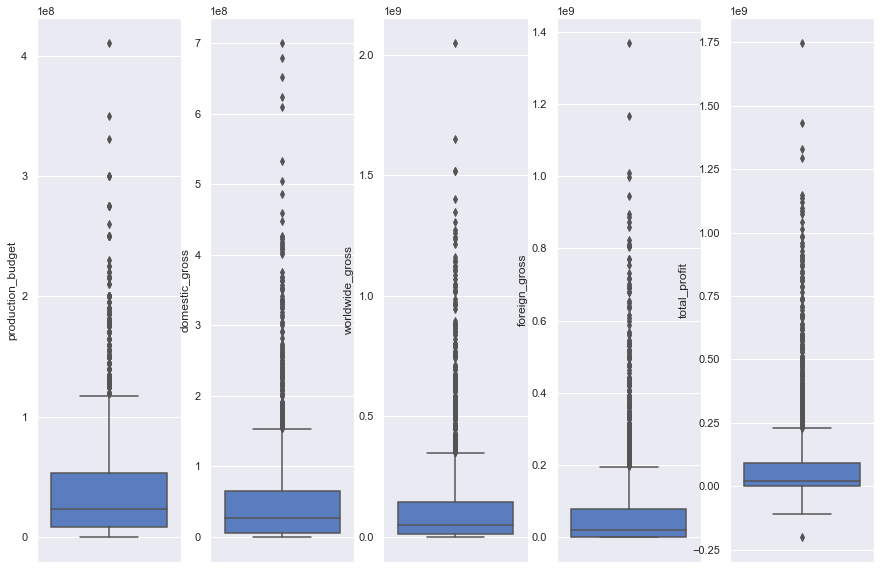

In [67]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(15,10))

ax_list = [ax1, ax2, ax3, ax4, ax5]
x = [df_int_movies_analysis_inner['production_budget'],
     df_int_movies_analysis_inner['domestic_gross'],
     df_int_movies_analysis_inner['worldwide_gross'],
     df_int_movies_analysis_inner['foreign_gross'],
     df_int_movies_analysis_inner['total_profit']]


for n in range(1,6):
    ax = ax_list[n-1]
    x_new = x[n-1]
    sns.set_style('darkgrid')
    sns.boxplot(x_new, ax=ax, orient='v')

In [451]:
df_int_movies_analysis_inner_cleaned['worldwide_gross'].mean()

131352261.2174399

In [ ]:
     ,
     df_int_movies_analysis_inner['domestic_profit'],
     

C:\Users\tcast\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


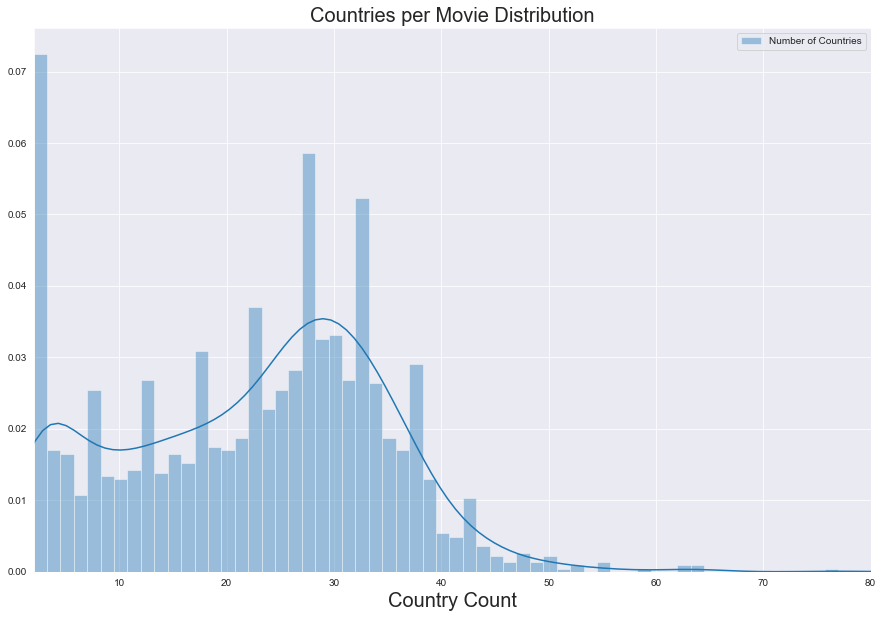

In [278]:
plt.figure(figsize=(15,10))
# sns.set(context=, style=, palette=, font=, font_scale=, color_codes=, rc=,)

bins=[2,12,22,32,42,52,62,72,82]
column = df_int_movies_analysis_inner['country_count']

# df_int_movies_analysis_inner\
# [(df_int_movies_analysis_inner['worldwide_gross']\
#  > df_int_movies_analysis_inner['worldwide_gross'].quantile(.01))\
#  & (df_int_movies_analysis_inner['worldwide_gross']\
#  < df_int_movies_analysis_inner['worldwide_gross'].quantile(.99))]\
# ['country_count']

sns.distplot(column, bins=60, norm_hist=False);

plt.xlabel('Country Count', fontsize=20)
plt.xlim(2,80)
plt.title('Countries per Movie Distribution', fontsize=20);
plt.legend(['Number of Countries']);

### This is after filtering for worldwide gross

In [279]:
df_int_movies_analysis_inner['country_count'].value_counts()

2     106
30     74
29     73
27     71
26     63
31     60
32     60
28     60
34     59
25     57
33     57
3      56
24     51
22     43
21     42
35     42
23     40
19     39
17     39
20     38
36     38
4      38
5      37
37     37
15     37
16     34
13     33
11     32
14     31
7      31
18     30
9      30
39     29
10     29
38     28
12     27
8      26
6      24
43     14
40     12
41     11
42      9
44      8
47      6
50      5
45      5
55      3
49      3
46      3
64      2
63      2
59      1
51      1
52      1
53      1
77      1
Name: country_count, dtype: int64

Above we can see that 2, and 3 countries rank quite high on the list.  We can also see that 4 and 5 aren't far behind.
Let's take a closer looks at those movies and see if there is anything special about those few countries

In [281]:
len(df_int_movies_analysis_inner[
    df_int_movies_analysis_inner['country_count'] <= 3])

162

In [282]:
ccount_cleaning = df_int_movies_analysis_inner[
    (df_int_movies_analysis_inner['country_count'] <= 3)
&
(df_int_movies_analysis_inner['foreign_gross'] > df_int_movies_analysis_inner['domestic_gross'])]
print(ccount_cleaning.shape)
ccount_cleaning.head()

(31, 11)


,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,domestic_profit,total_profit,return_on_investment
153,2005-06-29,War of the Worlds,132000000.0,234280354.0,606836535.0,"[United States, United Kingdom]",2,372556181.0,102280354.0,474836535.0,4.597246
273,1997-04-04,The Saint,90000000.0,61363304.0,169400000.0,"[Lithuania, Poland]",2,108036696.0,-28636696.0,79400000.0,1.882222
291,2002-03-15,Showtime,85000000.0,37948765.0,78948765.0,"[China, United States]",2,41000000.0,-47051235.0,-6051235.0,0.928809
326,1996-06-07,The Rock,75000000.0,134069511.0,336069511.0,"[Australia, Mexico]",2,202000000.0,59069511.0,261069511.0,4.480927
339,2000-11-22,Unbreakable,73243106.0,94999143.0,248099143.0,"[United Kingdom, Ireland]",2,153100000.0,21756037.0,174856037.0,3.387338


In [294]:
def country_count_category(value):
    if value <=10:
        value = '10 or less'
    elif value > 10 and value <= 20:
        value = '11 - 20'
    elif value > 20 and value <= 30:
        value = '21 - 30'
    elif value > 30 and value <= 40:
        value = '31 - 40'
    elif value > 40 and value <= 50:
        value = '41 - 50'
    elif value > 50 and value <= 60:
        value = '51 - 60'
    else: 
        value = '61 +'
    return value
    
df_int_movies_analysis_inner['country_count_category'] = df_int_movies_analysis_inner['country_count'].map(lambda x: country_count_category(x))
df_int_movies_analysis_inner

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,domestic_profit,total_profit,return_on_investment,country_count_category
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[Japan, Sweden, Peru, Ukraine, United States, ...",45,8.046000e+08,-169536125.0,6.350639e+08,2.546673,41 - 50
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[France, Mexico, Italy, Poland, Hungary, Portu...",34,1.070000e+08,-307237650.0,-2.002376e+08,0.427892,31 - 40
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[Azerbaijan, Peru, United States, Israel, Mexi...",39,9.440081e+08,128405868.0,1.072414e+09,4.243841,31 - 40
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[Argentina, Spain, Serbia, United States, Czec...",35,1.369319e+09,378815482.0,1.748134e+09,6.827114,31 - 40
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[Serbia, Argentina, United States, Hungary, Vi...",32,4.269209e+08,-70975705.0,3.559452e+08,2.186484,31 - 40
5,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08,"[Bulgaria, Portugal, Serbia, Russian Federatio...",30,6.795467e+08,-99925825.0,5.796209e+08,2.932070,21 - 30
6,2012-07-20,The Dark Knight Rises,275000000.0,448139099.0,1.084439e+09,"[Slovenia, Lithuania, Uruguay, Japan, United S...",50,6.363000e+08,173139099.0,8.094391e+08,3.943415,41 - 50
7,2018-05-25,Solo: A Star Wars Story,275000000.0,213767512.0,3.931513e+08,"[Sweden, Serbia, Hungary, Lithuania, Romania, ...",35,1.793838e+08,-61232488.0,1.181513e+08,1.429641,31 - 40
8,2013-07-02,The Lone Ranger,275000000.0,89302115.0,2.600021e+08,"[Italy, Ukraine, Slovakia, Venezuela, Bolivari...",34,1.707000e+08,-185697885.0,-1.499788e+07,0.945462,31 - 40
9,2012-03-09,John Carter,275000000.0,73058679.0,2.827781e+08,"[Ukraine, United States, Argentina, India, Lit...",33,2.097194e+08,-201941321.0,7.778100e+06,1.028284,31 - 40


In [306]:
df_int_movies_analysis_inner.describe()

,production_budget,domestic_gross,worldwide_gross,country_count,foreign_gross,domestic_profit,total_profit,return_on_investment
count,1.789000e+03,1.789000e+03,1.789000e+03,1789.000000,1.789000e+03,1.789000e+03,1.789000e+03,1789.000000
mean,4.238102e+07,5.404707e+07,1.313523e+08,22.494131,7.730520e+07,1.166605e+07,8.897125e+07,4.494683
std,5.280976e+07,8.054535e+07,2.196631e+08,12.072330,1.461847e+08,5.800161e+07,1.819336e+08,16.207823
min,9.000000e+03,3.880000e+02,5.280000e+02,2.000000,0.000000e+00,-3.072376e+08,-2.002376e+08,0.000138
25%,8.300000e+06,5.101237e+06,1.018205e+07,13.000000,1.316327e+06,-1.113704e+07,-7.181760e+05,0.846584
50%,2.300000e+07,2.710827e+07,4.842597e+07,25.000000,1.883104e+07,-1.279080e+05,2.155696e+07,2.178123
75%,5.100000e+07,6.447312e+07,1.425316e+08,31.000000,7.636106e+07,2.266441e+07,8.905244e+07,4.087030
max,4.106000e+08,7.000596e+08,2.048134e+09,77.000000,1.369319e+09,5.000596e+08,1.748134e+09,416.564740


C:\Users\tcast\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


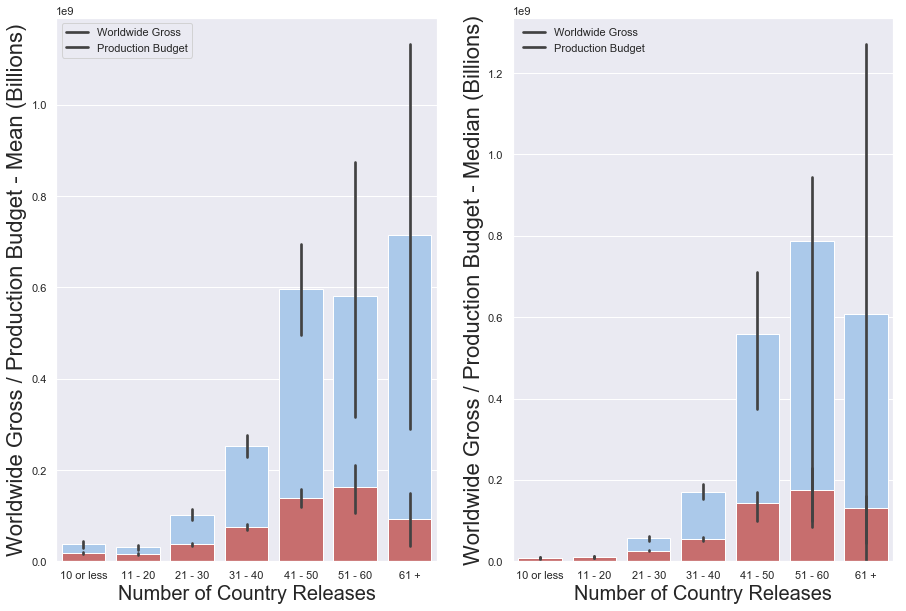

In [298]:
fig = plt.figure(figsize=(15,10))
sns.set(style='darkgrid')
order = ['10 or less', '11 - 20', '21 - 30', '31 - 40', '41 - 50', '51 - 60', '61 +']

ax1 = fig.add_subplot(121)

sns.set_color_codes('pastel')
sns.barplot(x='country_count_category',
            y='worldwide_gross',
            data=df_int_movies_analysis_inner,
            color='b',
            order=order,
            estimator=np.mean,
            ax=ax1);

sns.set_color_codes('muted')
sns.barplot(x='country_count_category',
            y='production_budget',
            data=df_int_movies_analysis_inner,
            color='r',
            order=order,
            estimator=np.mean,
            ax=ax1);

plt.legend(['Worldwide Gross', 'Production Budget'])
plt.ylabel('Worldwide Gross / Production Budget - Mean (Billions)', fontsize=22);
plt.xlabel('Number of Country Releases', fontsize=20);


ax2 = fig.add_subplot(122)

sns.set_color_codes('pastel')
sns.barplot(x='country_count_category',
            y='worldwide_gross',
            data=df_int_movies_analysis_inner,
            color='b',
            order=order,
            estimator=np.median,
            ax=ax2
           );

sns.set_color_codes('muted')
sns.barplot(x='country_count_category',
            y='production_budget',
            data=df_int_movies_analysis_inner,
            color='r',
            order=order,
            estimator=np.median,
            ax=ax2
           );

plt.legend(['Worldwide Gross', 'Production Budget'], frameon=False)
plt.ylabel('Worldwide Gross / Production Budget - Median (Billions)', fontsize=22);
plt.xlabel('Number of Country Releases', fontsize=20);

C:\Users\tcast\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


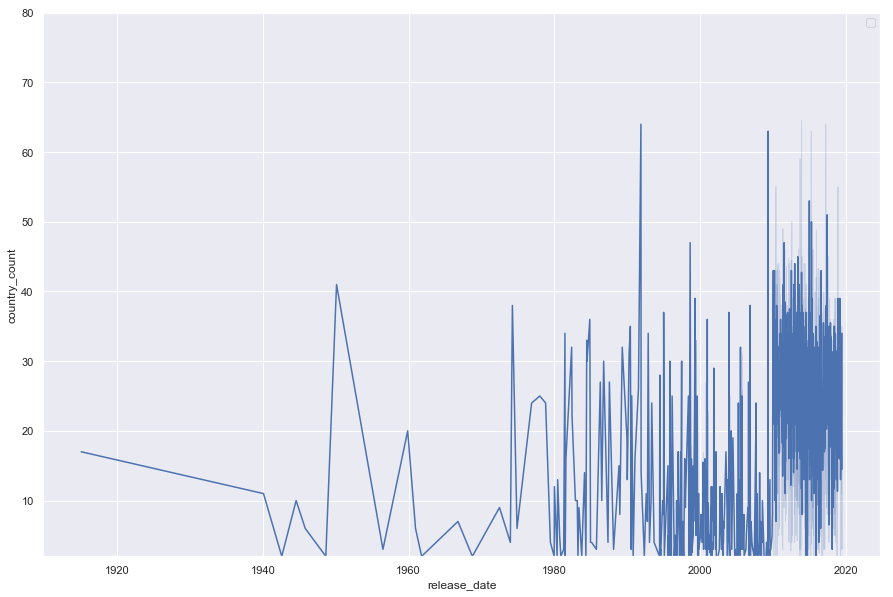

In [303]:
plt.figure(figsize=(15,10))
plt.ylim(2,80)
sns.lineplot(x='release_date', y='country_count', data=df_int_movies_analysis_inner);
# df_country_categories.plot.bar(y='total_profit', rot=0, figsize=(15,10));
# .plot.bar(x='country_count_category', y='total_profit')

plt.legend();

In [260]:
# calculate correlation matrix
corr = df_int_movies_analysis.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

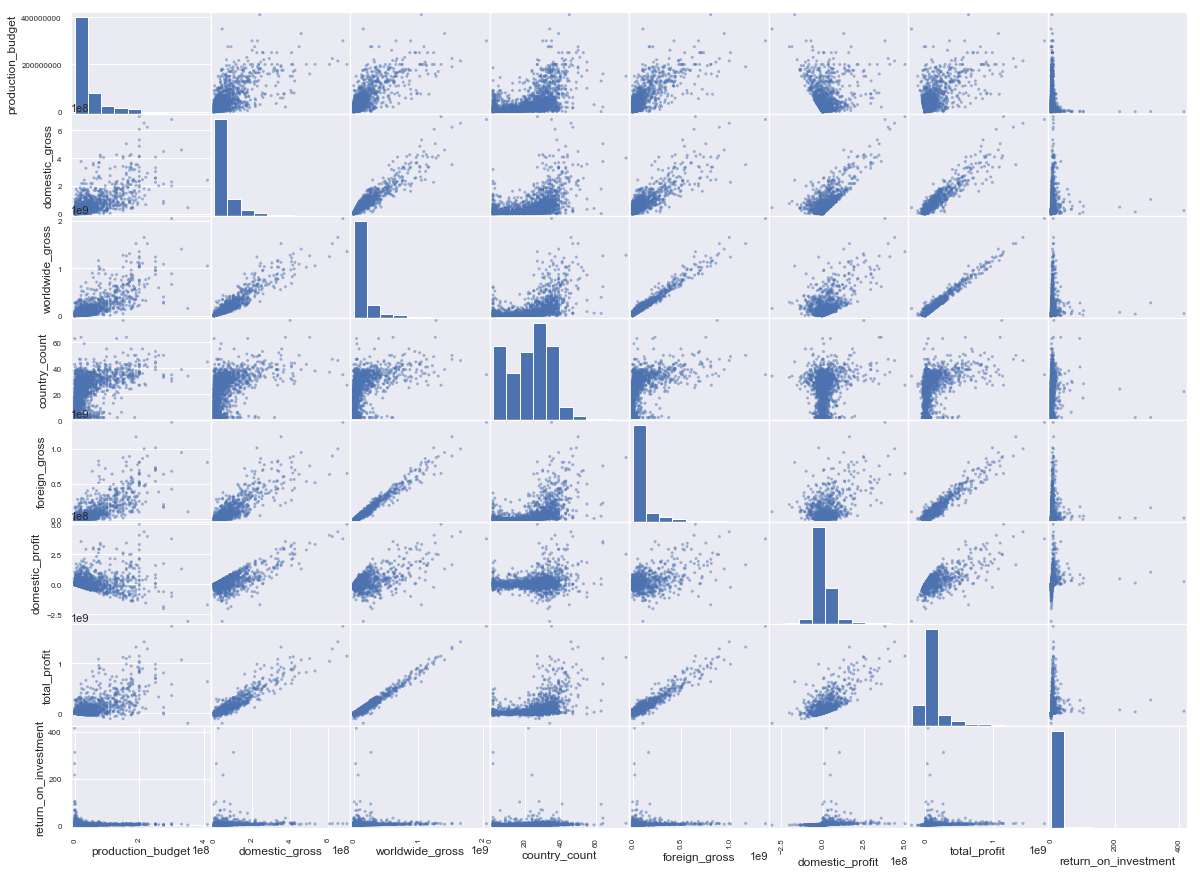

In [304]:
pd.plotting.scatter_matrix(df_int_movies_analysis_inner, figsize=(20,15), grid=True);